In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.model_selection import train_test_split
tf.get_logger().setLevel('INFO')

import os
from os import listdir
from PIL import Image

from imblearn.over_sampling import SMOTE

In [34]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara

# import sys
# !{sys.executable} -m pip install imbalanced-learn

In [2]:
df = pd.read_csv('KidneyImages/kidneyData.csv')

In [3]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [4]:
newsize = (256, 256)

In [5]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"


for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [6]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [7]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [8]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        reshapedImage = npImage[:, :, 0]
        npImage = np.asarray(image)

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [10]:
imgs

,image_id,image
0,Cyst- (630),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Cyst- (260),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Cyst- (1631),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Cyst- (1261),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Cyst- (1774),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
12441,Tumor- (209),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12442,Tumor- (1390),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12443,Tumor- (659),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12444,Tumor- (1685),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [12]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [13]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
###### First, we perform SMOTE

In [14]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

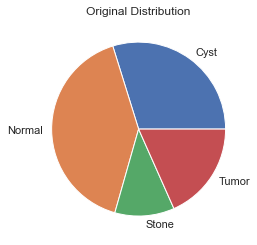

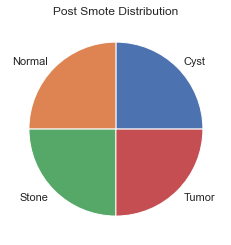

In [15]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [ ]:
###### Then we shuffle the data

In [45]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]

In [46]:
###### Then we split into train and test sets

In [59]:
X_train, X_test, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [60]:
# Create an intermediary validation set 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [61]:
X_train.shape

(12184, 65536)

In [28]:
X_train = np.stack(X_train, axis=0)
Y_train = np.stack(y_train, axis=0)
X_test = np.stack(X_test, axis=0)
Y_test = np.stack(y_test, axis=0)

In [29]:
X_train.shape

(16246, 65536)

In [62]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
   

    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      units=n_classes,
      activation="softmax"
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = build_multiclass_model(4, 0.01)

history = model.fit(
  x = X_train,
  y = y_train,
  epochs=5,
  batch_size=128,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
86/86 [==============================] - 2s 21ms/step - loss: 305181.4062 - accuracy: 0.4357 - val_loss: 73449.2266 - val_accuracy: 0.6538
Epoch 2/5
86/86 [==============================] - 2s 17ms/step - loss: 59488.1797 - accuracy: 0.7402 - val_loss: 17696.4980 - val_accuracy: 0.8482
Epoch 3/5
86/86 [==============================] - 2s 18ms/step - loss: 2216.5146 - accuracy: 0.9591 - val_loss: 1634.0101 - val_accuracy: 0.9688
Epoch 4/5
86/86 [==============================] - 1s 17ms/step - loss: 942.0218 - accuracy: 0.9780 - val_loss: 2076.0791 - val_accuracy: 0.9557
Epoch 5/5
86/86 [==============================] - 2s 21ms/step - loss: 558.5026 - accuracy: 0.9870 - val_loss: 1354.3282 - val_accuracy: 0.9705


,loss,accuracy,val_loss,val_accuracy
0,305181.406250,0.435659,73449.226562,0.653815
1,59488.179688,0.740173,17696.498047,0.848236
2,2216.514648,0.959052,1634.010132,0.968827
3,942.021790,0.978021,2076.079102,0.955701
4,558.502625,0.987050,1354.328247,0.970468


In [64]:
test_predictions = np.argmax(model.predict(X_val), axis=-1)
print(test_predictions)

127/127 [==============================] - 0s 2ms/step
[2 0 2 ... 3 1 0]


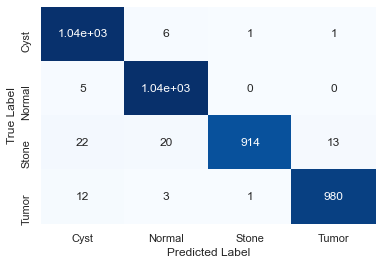

In [65]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'], 
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [35]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


In [37]:
# Change the shape
#### I don't think we need these anymore since I reshaped before smote!
# X_train = np.array([np.asarray(x).flatten() for x in X_train]).astype(np.float32)
# y_train = np.array([np.asarray(y) for y in y_train]).astype(np.float32)
# X_test = np.array([np.asarray(x).flatten() for x in X_train]).astype(np.float32)
# y_test = np.array([np.asarray(y) for y in y_train]).astype(np.float32)



# Build and compile the model
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='SGD', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)




Epoch 1/5
229/229 [==============================] - 9s 39ms/step - loss: 25753.7090 - accuracy: 0.2458 - val_loss: 1.3838 - val_accuracy: 0.2308
Epoch 2/5
229/229 [==============================] - 8s 37ms/step - loss: 1.3836 - accuracy: 0.2463 - val_loss: 1.3840 - val_accuracy: 0.2308
Epoch 3/5
229/229 [==============================] - 8s 37ms/step - loss: 1.3836 - accuracy: 0.2486 - val_loss: 1.3841 - val_accuracy: 0.2474
Epoch 4/5
229/229 [==============================] - 9s 38ms/step - loss: 1.3836 - accuracy: 0.2494 - val_loss: 1.3841 - val_accuracy: 0.2474
Epoch 5/5
229/229 [==============================] - 9s 38ms/step - loss: 1.3835 - accuracy: 0.2537 - val_loss: 1.3842 - val_accuracy: 0.2474
127/127 - 1s - loss: 1.3847 - accuracy: 0.2464 - 830ms/epoch - 7ms/step


In [26]:
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='RMSprop', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/5
140/140 [==============================] - 5s 36ms/step - loss: 7473.9858 - accuracy: 0.6464 - val_loss: 2.0338 - val_accuracy: 0.5472
Epoch 2/5
140/140 [==============================] - 5s 35ms/step - loss: 8.0220 - accuracy: 0.5817 - val_loss: 1.0464 - val_accuracy: 0.5100
Epoch 3/5
140/140 [==============================] - 5s 36ms/step - loss: 1.7319 - accuracy: 0.5280 - val_loss: 1.1232 - val_accuracy: 0.5050
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 1.1079 - accuracy: 0.5205 - val_loss: 1.1233 - val_accuracy: 0.5050
Epoch 5/5
140/140 [==============================] - 5s 37ms/step - loss: 1.1077 - accuracy: 0.5205 - val_loss: 1.1227 - val_accuracy: 0.5050
312/312 - 2s - loss: 1.1100 - accuracy: 0.5190 - 2s/epoch - 6ms/step


In [27]:
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/5
140/140 [==============================] - 6s 43ms/step - loss: 1452.7842 - accuracy: 0.5614 - val_loss: 0.9824 - val_accuracy: 0.5994
Epoch 2/5
140/140 [==============================] - 6s 43ms/step - loss: 0.8948 - accuracy: 0.6442 - val_loss: 0.9066 - val_accuracy: 0.6245
Epoch 3/5
140/140 [==============================] - 6s 41ms/step - loss: 0.8717 - accuracy: 0.6613 - val_loss: 0.8876 - val_accuracy: 0.6325
Epoch 4/5
140/140 [==============================] - 6s 41ms/step - loss: 0.8711 - accuracy: 0.6536 - val_loss: 0.8465 - val_accuracy: 0.6456
Epoch 5/5
140/140 [==============================] - 6s 41ms/step - loss: 0.8307 - accuracy: 0.7048 - val_loss: 0.7474 - val_accuracy: 0.6988
312/312 - 2s - loss: 0.7713 - accuracy: 0.7094 - 2s/epoch - 6ms/step
